# Clean Pipeline v2: Price Model for Appreciation

## Decisions Made

**1. Target Population:**
- Price range: $170,000 - $1,000,000 only
- Metros: 10 training groups (DFW combined, South Florida combined)
- Display: 12 metros for user filtering

**2. Data Quality:**
- Minimum history: 60 months (5 years)
- Missing values: Drop entirely (no imputation)

**3. Training Periods:**
- Model A: 2000 - October 2025 (includes COVID)
- Model B: 2000 - January 2020 (pre-COVID)
- Test: November 2025 actuals

**4. Prediction Target:**
- 1-year price prediction
- Appreciation = (predicted - current) / current
- Multi-year: compound (1 + rate)^years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

pd.set_option('display.max_columns', 50)
print(f'Notebook run: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Notebook run: 2026-01-01 21:08


## Step 1: Load Raw Data

In [2]:
# Load training data (through Oct 2025)
df_train_raw = pd.read_csv('../data/raw/zillow_zhvi_neighborhoods.csv')

# Load test data (includes Nov 2025)
df_test_raw = pd.read_csv('../data/raw/zillow_zhvi_neighborhoods_updated.csv')

# Identify columns
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
date_cols_train = [col for col in df_train_raw.columns if col not in metadata_cols]
date_cols_test = [col for col in df_test_raw.columns if col not in metadata_cols]

print(f'Training data: {len(df_train_raw):,} neighborhoods')
print(f'Training dates: {date_cols_train[0]} to {date_cols_train[-1]}')
print(f'Test dates: {date_cols_test[0]} to {date_cols_test[-1]}')

Training data: 21,616 neighborhoods
Training dates: 2000-01-31 to 2025-10-31
Test dates: 2000-01-31 to 2025-11-30


## Step 2: Filter to Target Population

In [3]:
# Metro assignment for training (combined groups)
def get_training_metro(metro_val):
    metro_val = str(metro_val).lower()
    if 'houston' in metro_val: return 'houston'
    if 'dallas' in metro_val or 'fort worth' in metro_val: return 'dfw'
    if 'austin' in metro_val: return 'austin'
    if 'san antonio' in metro_val: return 'san_antonio'
    if 'abilene' in metro_val: return 'abilene'
    if 'waco' in metro_val: return 'waco'
    if 'orlando' in metro_val: return 'orlando'
    if 'tampa' in metro_val: return 'tampa'
    if 'miami' in metro_val or 'fort lauderdale' in metro_val: return 'south_florida'
    if 'jacksonville' in metro_val: return 'jacksonville'
    return None

# Metro assignment for display (separate for user filtering)
def get_display_metro(row):
    metro_val = str(row['Metro']).lower()
    city = str(row['City']).lower()
    
    if 'dallas' in metro_val or 'fort worth' in metro_val:
        if 'fort worth' in city or city in ['arlington', 'mansfield', 'burleson', 'keller']:
            return 'fort_worth'
        return 'dallas'
    
    if 'miami' in metro_val or 'fort lauderdale' in metro_val:
        if 'fort lauderdale' in city or 'pompano' in city or 'hollywood' in city:
            return 'fort_lauderdale'
        return 'miami'
    
    if 'houston' in metro_val: return 'houston'
    if 'austin' in metro_val: return 'austin'
    if 'san antonio' in metro_val: return 'san_antonio'
    if 'abilene' in metro_val: return 'abilene'
    if 'waco' in metro_val: return 'waco'
    if 'orlando' in metro_val: return 'orlando'
    if 'tampa' in metro_val: return 'tampa'
    if 'jacksonville' in metro_val: return 'jacksonville'
    return None

In [4]:
# Apply metro filter
df = df_train_raw.copy()
df['training_metro'] = df['Metro'].apply(get_training_metro)
df['display_metro'] = df.apply(get_display_metro, axis=1)

df = df[df['training_metro'].notna()].copy()
print(f'After metro filter: {len(df):,} neighborhoods')
print()
print('Training metros:')
print(df['training_metro'].value_counts())

After metro filter: 4,648 neighborhoods

Training metros:
training_metro
dfw              1521
south_florida     917
houston           759
tampa             542
san_antonio       327
jacksonville      191
austin            185
orlando           161
waco               23
abilene            22
Name: count, dtype: int64


In [5]:
# Apply price filter ($170k - $1M using Oct 2025 prices)
oct_2025_col = '2025-10-31'
df['current_price'] = df[oct_2025_col]

before = len(df)
df = df[(df['current_price'] >= 170000) & (df['current_price'] <= 1000000)].copy()
after = len(df)

print(f'Price filter ($170k - $1M):')
print(f'  Before: {before:,}')
print(f'  After: {after:,}')
print(f'  Removed: {before - after:,}')

Price filter ($170k - $1M):
  Before: 4,648
  After: 4,194
  Removed: 454


In [6]:
# Check history length for each neighborhood
def count_valid_months(row):
    prices = row[date_cols_train].values
    return (~pd.isna(prices)).sum()

df['history_months'] = df.apply(count_valid_months, axis=1)

# Apply 60-month minimum
before = len(df)
df = df[df['history_months'] >= 60].copy()
after = len(df)

print(f'History filter (60+ months):')
print(f'  Before: {before:,}')
print(f'  After: {after:,}')
print(f'  Removed: {before - after:,}')
print()
print(f'FINAL CLEAN NEIGHBORHOODS: {len(df):,}')

History filter (60+ months):
  Before: 4,194
  After: 3,148
  Removed: 1,046

FINAL CLEAN NEIGHBORHOODS: 3,148


In [7]:
# Summary of clean dataset
print('=== CLEAN DATASET SUMMARY ===')
print(f'Total neighborhoods: {len(df):,}')
print()
print('By training metro:')
print(df['training_metro'].value_counts())
print()
print('Price range:')
print(f'  Min: ${df["current_price"].min():,.0f}')
print(f'  Max: ${df["current_price"].max():,.0f}')
print(f'  Median: ${df["current_price"].median():,.0f}')
print()
print('History range:')
print(f'  Min: {df["history_months"].min()} months')
print(f'  Max: {df["history_months"].max()} months')

=== CLEAN DATASET SUMMARY ===
Total neighborhoods: 3,148

By training metro:
training_metro
dfw              1272
south_florida     587
tampa             279
san_antonio       261
houston           239
austin            179
jacksonville      157
orlando           150
waco               13
abilene            11
Name: count, dtype: int64

Price range:
  Min: $170,132
  Max: $996,496
  Median: $375,618

History range:
  Min: 60 months
  Max: 310 months


## Step 3: Feature Extraction

16 features, no imputation. If any feature cannot be calculated, drop the example.

In [8]:
def extract_features(prices, metro_median):
    """
    Extract 16 features from price history.
    Returns None if any feature cannot be calculated (no imputation).
    """
    valid_mask = ~np.isnan(prices)
    valid_prices = prices[valid_mask]
    n = len(valid_prices)
    
    # Require 60+ months for cagr_5yr
    if n < 60:
        return None
    
    features = {}
    
    # === TREND FEATURES ===
    features['prev_price'] = valid_prices[-1]
    features['log_prev_price'] = np.log(valid_prices[-1])
    
    # CAGRs
    if n >= 12:
        features['cagr_1yr'] = ((valid_prices[-1] / valid_prices[-12]) - 1) * 100
    else:
        return None
        
    if n >= 36:
        features['cagr_3yr'] = (((valid_prices[-1] / valid_prices[-36]) ** (1/3)) - 1) * 100
    else:
        return None
        
    if n >= 60:
        features['cagr_5yr'] = (((valid_prices[-1] / valid_prices[-60]) ** (1/5)) - 1) * 100
    else:
        return None
    
    years_of_data = n / 12
    features['cagr_full'] = (((valid_prices[-1] / valid_prices[0]) ** (1/years_of_data)) - 1) * 100
    
    # === MOMENTUM FEATURES ===
    features['trend_acceleration'] = features['cagr_3yr'] - features['cagr_full']
    
    if n >= 3:
        features['momentum_3m'] = ((valid_prices[-1] / valid_prices[-3]) - 1) * 100
    else:
        return None
    
    # === VOLATILITY FEATURES ===
    returns = np.diff(valid_prices) / valid_prices[:-1] * 100
    features['volatility'] = np.std(returns)
    
    negative_returns = returns[returns < 0]
    features['downside_volatility'] = np.std(negative_returns) if len(negative_returns) > 0 else 0
    
    cummax = np.maximum.accumulate(valid_prices)
    drawdowns = (cummax - valid_prices) / cummax * 100
    features['max_drawdown'] = np.max(drawdowns)
    
    # === CYCLE FEATURES ===
    peak_price = np.max(valid_prices)
    features['distance_from_peak'] = ((valid_prices[-1] / peak_price) - 1) * 100
    
    peak_idx = np.argmax(valid_prices)
    features['months_since_peak'] = len(valid_prices) - peak_idx - 1
    
    # === RELATIVE FEATURES ===
    if metro_median > 0:
        features['price_to_metro_median'] = valid_prices[-1] / metro_median
    else:
        return None
    
    # === DATA QUALITY ===
    features['data_coverage'] = valid_mask.sum() / len(prices) * 100
    features['history_months'] = n
    
    # Final NaN check
    if any(np.isnan(v) if isinstance(v, float) else False for v in features.values()):
        return None
    
    return features

print('Feature extraction function defined.')

Feature extraction function defined.


In [9]:
# Create year-to-column mapping
date_cols_dt = pd.to_datetime(date_cols_train)

def find_jan_column(year):
    target = pd.to_datetime(f'{year}-01-31')
    diffs = abs(date_cols_dt - target)
    closest_idx = diffs.argmin()
    return date_cols_train[closest_idx], closest_idx

year_to_col = {}
for year in range(2000, 2026):
    col, idx = find_jan_column(year)
    year_to_col[year] = (col, idx)

print('Year to column mapping:')
for year in [2000, 2005, 2010, 2015, 2020, 2025]:
    print(f'  {year}: {year_to_col[year][0]}')

Year to column mapping:
  2000: 2000-01-31
  2005: 2005-01-31
  2010: 2010-01-31
  2015: 2015-01-31
  2020: 2020-01-31
  2025: 2025-01-31


In [10]:
# Create training examples for MODEL A (2000-Oct 2025)
# Example: (neighborhood, year T) -> features at T, target = price at T+1

print('Creating training examples for Model A (2000-Oct 2025)...')
print('This may take a few minutes.\n')

examples_a = []

for start_year in range(2005, 2025):  # 2005-2024 (need 5yr history, need T+1 target)
    end_year = start_year + 1
    
    start_col, start_idx = year_to_col[start_year]
    end_col, end_idx = year_to_col[end_year]
    
    # Compute metro medians at start time
    metro_medians = {}
    for metro in df['training_metro'].unique():
        metro_prices = df[df['training_metro'] == metro][start_col].dropna()
        if len(metro_prices) > 0:
            metro_medians[metro] = metro_prices.median()
    
    count = 0
    for idx, row in df.iterrows():
        # Get price history up to start_year
        history = row[date_cols_train[:start_idx]].values.astype(float)
        
        features = extract_features(history, metro_medians.get(row['training_metro'], 0))
        
        if features is None:
            continue
        
        # Get target price (T+1)
        target_price = row[end_col]
        if pd.isna(target_price) or target_price <= 0:
            continue
        
        # Check price bounds
        if features['prev_price'] < 170000 or features['prev_price'] > 1000000:
            continue
        
        features['neighborhood_id'] = row['RegionID']
        features['neighborhood_name'] = row['RegionName']
        features['city'] = row['City']
        features['training_metro'] = row['training_metro']
        features['display_metro'] = row['display_metro']
        features['start_year'] = start_year
        features['target_price'] = target_price
        
        examples_a.append(features)
        count += 1
    
    print(f'  {start_year}: {count:,} examples')

df_model_a = pd.DataFrame(examples_a)
print(f'\nModel A total: {len(df_model_a):,} examples')

Creating training examples for Model A (2000-Oct 2025)...
This may take a few minutes.

  2005: 648 examples
  2006: 872 examples
  2007: 1,010 examples
  2008: 1,025 examples
  2009: 843 examples
  2010: 789 examples
  2011: 758 examples
  2012: 754 examples
  2013: 900 examples
  2014: 1,134 examples
  2015: 1,375 examples
  2016: 1,658 examples
  2017: 1,957 examples
  2018: 2,248 examples
  2019: 2,427 examples
  2020: 2,558 examples
  2021: 2,721 examples
  2022: 2,938 examples
  2023: 3,012 examples
  2024: 3,067 examples

Model A total: 32,694 examples


In [11]:
# Create training examples for MODEL B (2000-Jan 2020)
# Only use years 2005-2019 (pre-COVID)

print('Creating training examples for Model B (2000-Jan 2020)...')

# Filter Model A examples to pre-COVID only
df_model_b = df_model_a[df_model_a['start_year'] <= 2019].copy()

print(f'Model B total: {len(df_model_b):,} examples')
print(f'Year range: {df_model_b["start_year"].min()} - {df_model_b["start_year"].max()}')

Creating training examples for Model B (2000-Jan 2020)...
Model B total: 18,398 examples
Year range: 2005 - 2019


In [12]:
# Verify no NaN in features
feature_cols = ['prev_price', 'log_prev_price', 'cagr_1yr', 'cagr_3yr', 'cagr_5yr', 
                'cagr_full', 'trend_acceleration', 'momentum_3m', 'volatility',
                'downside_volatility', 'max_drawdown', 'distance_from_peak',
                'months_since_peak', 'price_to_metro_median', 'data_coverage', 'history_months']

print('=== NaN CHECK ===')
print('Model A:')
nan_count_a = df_model_a[feature_cols].isna().sum().sum()
print(f'  Total NaN: {nan_count_a}')

print('Model B:')
nan_count_b = df_model_b[feature_cols].isna().sum().sum()
print(f'  Total NaN: {nan_count_b}')

if nan_count_a == 0 and nan_count_b == 0:
    print('\n*** CLEAN DATASET - NO IMPUTATION NEEDED ***')

=== NaN CHECK ===
Model A:
  Total NaN: 0
Model B:
  Total NaN: 0

*** CLEAN DATASET - NO IMPUTATION NEEDED ***


## Step 4: Train Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print('ML libraries loaded.')

ML libraries loaded.


In [14]:
# Train Model A (includes COVID)
print('=== TRAINING MODEL A (2005-2024, includes COVID) ===')

X_a = df_model_a[feature_cols].values
y_a = df_model_a['target_price'].values

# 80/20 split
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(
    X_a, y_a, test_size=0.2, random_state=42
)

print(f'Train: {len(X_train_a):,}, Validation: {len(X_val_a):,}')

model_a = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
model_a.fit(X_train_a, y_train_a)

# Validation metrics
y_pred_a = model_a.predict(X_val_a)
mape_a = mean_absolute_percentage_error(y_val_a, y_pred_a) * 100
r2_a = r2_score(y_val_a, y_pred_a)

print(f'\nModel A Validation:')
print(f'  MAPE: {mape_a:.2f}%')
print(f'  R²: {r2_a:.4f}')

=== TRAINING MODEL A (2005-2024, includes COVID) ===
Train: 26,155, Validation: 6,539

Model A Validation:
  MAPE: 2.76%
  R²: 0.9894


In [15]:
# Train Model B (pre-COVID only)
print('=== TRAINING MODEL B (2005-2019, pre-COVID) ===')

X_b = df_model_b[feature_cols].values
y_b = df_model_b['target_price'].values

# 80/20 split
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_b, y_b, test_size=0.2, random_state=42
)

print(f'Train: {len(X_train_b):,}, Validation: {len(X_val_b):,}')

model_b = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
model_b.fit(X_train_b, y_train_b)

# Validation metrics
y_pred_b = model_b.predict(X_val_b)
mape_b = mean_absolute_percentage_error(y_val_b, y_pred_b) * 100
r2_b = r2_score(y_val_b, y_pred_b)

print(f'\nModel B Validation:')
print(f'  MAPE: {mape_b:.2f}%')
print(f'  R²: {r2_b:.4f}')

=== TRAINING MODEL B (2005-2019, pre-COVID) ===
Train: 14,718, Validation: 3,680

Model B Validation:
  MAPE: 2.70%
  R²: 0.9833


## Step 5: Forward Validation (November 2025)

In [16]:
# Load test data with November 2025 actuals
df_test = df_test_raw.copy()
df_test['training_metro'] = df_test['Metro'].apply(get_training_metro)
df_test['display_metro'] = df_test.apply(get_display_metro, axis=1)

# Apply same filters
nov_2025_col = '2025-11-30'
oct_2025_col = '2025-10-31'

df_test = df_test[df_test['training_metro'].notna()].copy()
df_test = df_test[
    (df_test[oct_2025_col] >= 170000) & 
    (df_test[oct_2025_col] <= 1000000)
].copy()

print(f'Test neighborhoods: {len(df_test):,}')

Test neighborhoods: 4,200


In [17]:
# Extract October 2025 features for prediction
date_cols_test_dt = pd.to_datetime(date_cols_test)
oct_idx = list(date_cols_test).index(oct_2025_col)

# Compute metro medians at Oct 2025
metro_medians_test = {}
for metro in df_test['training_metro'].unique():
    metro_prices = df_test[df_test['training_metro'] == metro][oct_2025_col].dropna()
    if len(metro_prices) > 0:
        metro_medians_test[metro] = metro_prices.median()

# Extract features
test_examples = []

for idx, row in df_test.iterrows():
    history = row[date_cols_test[:oct_idx+1]].values.astype(float)
    
    features = extract_features(history, metro_medians_test.get(row['training_metro'], 0))
    
    if features is None:
        continue
    
    # Get actual November 2025 price
    actual_nov = row[nov_2025_col]
    if pd.isna(actual_nov) or actual_nov <= 0:
        continue
    
    features['neighborhood_id'] = row['RegionID']
    features['neighborhood_name'] = row['RegionName']
    features['training_metro'] = row['training_metro']
    features['actual_nov_2025'] = actual_nov
    
    test_examples.append(features)

df_forward = pd.DataFrame(test_examples)
print(f'Forward validation examples: {len(df_forward):,}')

Forward validation examples: 3,155


In [18]:
# Predict November 2025 with both models
X_forward = df_forward[feature_cols].values
y_actual = df_forward['actual_nov_2025'].values

# Model A predictions
y_pred_a_fwd = model_a.predict(X_forward)

# Model B predictions
y_pred_b_fwd = model_b.predict(X_forward)

df_forward['pred_model_a'] = y_pred_a_fwd
df_forward['pred_model_b'] = y_pred_b_fwd

print('Predictions generated for both models.')

Predictions generated for both models.


In [19]:
# Compare forward validation results
print('=== FORWARD VALIDATION: NOVEMBER 2025 ===')
print()

# Model A
mape_a_fwd = mean_absolute_percentage_error(y_actual, y_pred_a_fwd) * 100
r2_a_fwd = r2_score(y_actual, y_pred_a_fwd)
mae_a_fwd = mean_absolute_error(y_actual, y_pred_a_fwd)

print('MODEL A (includes COVID):')
print(f'  MAPE: {mape_a_fwd:.2f}%')
print(f'  MAE: ${mae_a_fwd:,.0f}')
print(f'  R²: {r2_a_fwd:.4f}')
print()

# Model B
mape_b_fwd = mean_absolute_percentage_error(y_actual, y_pred_b_fwd) * 100
r2_b_fwd = r2_score(y_actual, y_pred_b_fwd)
mae_b_fwd = mean_absolute_error(y_actual, y_pred_b_fwd)

print('MODEL B (pre-COVID only):')
print(f'  MAPE: {mape_b_fwd:.2f}%')
print(f'  MAE: ${mae_b_fwd:,.0f}')
print(f'  R²: {r2_b_fwd:.4f}')
print()

# Winner
print('='*40)
if mape_a_fwd < mape_b_fwd:
    print(f'WINNER: Model A (COVID data helps)')
    print(f'  Improvement: {mape_b_fwd - mape_a_fwd:.2f}% lower MAPE')
else:
    print(f'WINNER: Model B (pre-COVID patterns better)')
    print(f'  Improvement: {mape_a_fwd - mape_b_fwd:.2f}% lower MAPE')

=== FORWARD VALIDATION: NOVEMBER 2025 ===

MODEL A (includes COVID):
  MAPE: 2.58%
  MAE: $10,249
  R²: 0.9916

MODEL B (pre-COVID only):
  MAPE: 4.96%
  MAE: $22,224
  R²: 0.9350

WINNER: Model A (COVID data helps)
  Improvement: 2.38% lower MAPE


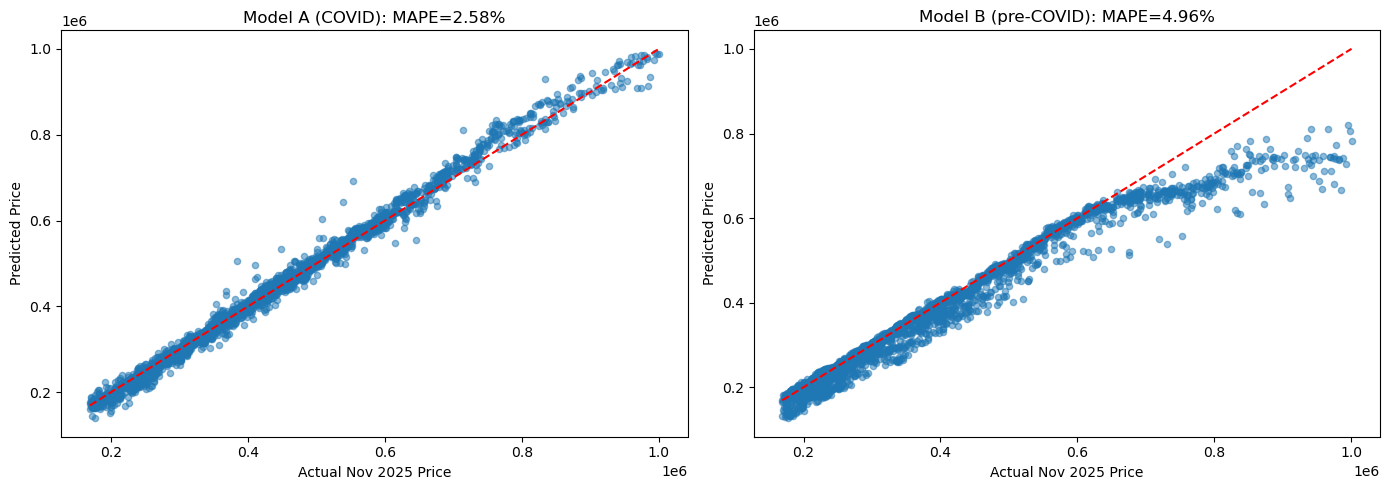

In [20]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model A
ax = axes[0]
ax.scatter(y_actual, y_pred_a_fwd, alpha=0.5, s=20)
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
ax.set_xlabel('Actual Nov 2025 Price')
ax.set_ylabel('Predicted Price')
ax.set_title(f'Model A (COVID): MAPE={mape_a_fwd:.2f}%')

# Model B
ax = axes[1]
ax.scatter(y_actual, y_pred_b_fwd, alpha=0.5, s=20)
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
ax.set_xlabel('Actual Nov 2025 Price')
ax.set_ylabel('Predicted Price')
ax.set_title(f'Model B (pre-COVID): MAPE={mape_b_fwd:.2f}%')

plt.tight_layout()
plt.show()

## Step 6: Decision

Based on forward validation results, decide:
1. Which model to use
2. If COVID data is needed, discuss weighting strategy

In [21]:
# Save results for discussion
results = {
    'model_a': {
        'description': '2005-2024 (includes COVID)',
        'train_examples': len(df_model_a),
        'validation_mape': mape_a,
        'forward_mape': mape_a_fwd,
        'forward_r2': r2_a_fwd
    },
    'model_b': {
        'description': '2005-2019 (pre-COVID)',
        'train_examples': len(df_model_b),
        'validation_mape': mape_b,
        'forward_mape': mape_b_fwd,
        'forward_r2': r2_b_fwd
    }
}

print('Results saved for discussion.')
print()
print('NEXT STEP: Review results and decide on final model approach.')

Results saved for discussion.

NEXT STEP: Review results and decide on final model approach.


## Step 7: Model C - 24-Month Lookback Test

**Hypothesis:** A shorter lookback window (24 months vs 60 months) may:
- Still capture COVID patterns but with less historical weight
- Be more responsive to recent market dynamics
- Reduce the influence of distant historical patterns

**Changes from Model A:**
- Minimum history: 24 months (vs 60)
- Features: Drop cagr_5yr, cagr_3yr; Add cagr_2yr
- More neighborhoods qualify (shorter history requirement)

In [22]:
def extract_features_24m(prices, metro_median):
    """
    Extract features from price history with 24-month minimum.
    Drops cagr_5yr and cagr_3yr, adds cagr_2yr.
    Returns None if any feature cannot be calculated (no imputation).
    """
    valid_mask = ~np.isnan(prices)
    valid_prices = prices[valid_mask]
    n = len(valid_prices)
    
    # Require 24+ months for cagr_2yr
    if n < 24:
        return None
    
    features = {}
    
    # === TREND FEATURES ===
    features['prev_price'] = valid_prices[-1]
    features['log_prev_price'] = np.log(valid_prices[-1])
    
    # CAGRs (modified for 24-month lookback)
    if n >= 12:
        features['cagr_1yr'] = ((valid_prices[-1] / valid_prices[-12]) - 1) * 100
    else:
        return None
        
    if n >= 24:
        features['cagr_2yr'] = (((valid_prices[-1] / valid_prices[-24]) ** (1/2)) - 1) * 100
    else:
        return None
    
    years_of_data = n / 12
    features['cagr_full'] = (((valid_prices[-1] / valid_prices[0]) ** (1/years_of_data)) - 1) * 100
    
    # === MOMENTUM FEATURES ===
    features['trend_acceleration'] = features['cagr_2yr'] - features['cagr_full']
    
    if n >= 3:
        features['momentum_3m'] = ((valid_prices[-1] / valid_prices[-3]) - 1) * 100
    else:
        return None
    
    # === VOLATILITY FEATURES ===
    returns = np.diff(valid_prices) / valid_prices[:-1] * 100
    features['volatility'] = np.std(returns)
    
    negative_returns = returns[returns < 0]
    features['downside_volatility'] = np.std(negative_returns) if len(negative_returns) > 0 else 0
    
    cummax = np.maximum.accumulate(valid_prices)
    drawdowns = (cummax - valid_prices) / cummax * 100
    features['max_drawdown'] = np.max(drawdowns)
    
    # === CYCLE FEATURES ===
    peak_price = np.max(valid_prices)
    features['distance_from_peak'] = ((valid_prices[-1] / peak_price) - 1) * 100
    
    peak_idx = np.argmax(valid_prices)
    features['months_since_peak'] = len(valid_prices) - peak_idx - 1
    
    # === RELATIVE FEATURES ===
    if metro_median > 0:
        features['price_to_metro_median'] = valid_prices[-1] / metro_median
    else:
        return None
    
    # === DATA QUALITY ===
    features['data_coverage'] = valid_mask.sum() / len(prices) * 100
    features['history_months'] = n
    
    # Final NaN check
    if any(np.isnan(v) if isinstance(v, float) else False for v in features.values()):
        return None
    
    return features

print('24-month feature extraction function defined.')
print()
print('Feature changes from 60-month version:')
print('  - REMOVED: cagr_5yr, cagr_3yr')
print('  - ADDED: cagr_2yr')
print('  - CHANGED: trend_acceleration now uses cagr_2yr')
print('  - Total features: 14 (down from 16)')

24-month feature extraction function defined.

Feature changes from 60-month version:
  - REMOVED: cagr_5yr, cagr_3yr
  - ADDED: cagr_2yr
  - CHANGED: trend_acceleration now uses cagr_2yr
  - Total features: 14 (down from 16)


In [23]:
# Re-filter data with 24-month minimum history
# Start from the metro-filtered, price-filtered data

df_24m = df_train_raw.copy()
df_24m['training_metro'] = df_24m['Metro'].apply(get_training_metro)
df_24m['display_metro'] = df_24m.apply(get_display_metro, axis=1)

# Metro filter
df_24m = df_24m[df_24m['training_metro'].notna()].copy()
print(f'After metro filter: {len(df_24m):,} neighborhoods')

# Price filter
df_24m['current_price'] = df_24m[oct_2025_col]
df_24m = df_24m[(df_24m['current_price'] >= 170000) & (df_24m['current_price'] <= 1000000)].copy()
print(f'After price filter: {len(df_24m):,} neighborhoods')

# 24-month history filter (vs 60-month for Model A/B)
df_24m['history_months'] = df_24m.apply(count_valid_months, axis=1)
df_24m = df_24m[df_24m['history_months'] >= 24].copy()
print(f'After 24-month history filter: {len(df_24m):,} neighborhoods')

# Compare to 60-month filter
print()
print(f'=== COMPARISON ===')
print(f'60-month filter: {len(df):,} neighborhoods (Model A/B)')
print(f'24-month filter: {len(df_24m):,} neighborhoods (Model C)')
print(f'Additional neighborhoods: {len(df_24m) - len(df):,} ({(len(df_24m) - len(df)) / len(df) * 100:.1f}% more)')

After metro filter: 4,648 neighborhoods
After price filter: 4,194 neighborhoods
After 24-month history filter: 3,677 neighborhoods

=== COMPARISON ===
60-month filter: 3,148 neighborhoods (Model A/B)
24-month filter: 3,677 neighborhoods (Model C)
Additional neighborhoods: 529 (16.8% more)


In [24]:
# Create training examples for MODEL C (24-month lookback, 2002-Oct 2025)
# Can start at 2002 (need only 2 years of history instead of 5)

print('Creating training examples for Model C (24-month lookback)...')
print('This may take a few minutes.\n')

# Define the 14 features for Model C (no cagr_5yr, cagr_3yr; has cagr_2yr)
feature_cols_24m = ['prev_price', 'log_prev_price', 'cagr_1yr', 'cagr_2yr',
                    'cagr_full', 'trend_acceleration', 'momentum_3m', 'volatility',
                    'downside_volatility', 'max_drawdown', 'distance_from_peak',
                    'months_since_peak', 'price_to_metro_median', 'data_coverage', 'history_months']

examples_c = []

for start_year in range(2002, 2025):  # 2002-2024 (need 2yr history, need T+1 target)
    end_year = start_year + 1
    
    start_col, start_idx = year_to_col[start_year]
    end_col, end_idx = year_to_col[end_year]
    
    # Compute metro medians at start time
    metro_medians = {}
    for metro in df_24m['training_metro'].unique():
        metro_prices = df_24m[df_24m['training_metro'] == metro][start_col].dropna()
        if len(metro_prices) > 0:
            metro_medians[metro] = metro_prices.median()
    
    count = 0
    for idx, row in df_24m.iterrows():
        # Get price history up to start_year
        history = row[date_cols_train[:start_idx]].values.astype(float)
        
        features = extract_features_24m(history, metro_medians.get(row['training_metro'], 0))
        
        if features is None:
            continue
        
        # Get target price (T+1)
        target_price = row[end_col]
        if pd.isna(target_price) or target_price <= 0:
            continue
        
        # Check price bounds
        if features['prev_price'] < 170000 or features['prev_price'] > 1000000:
            continue
        
        features['neighborhood_id'] = row['RegionID']
        features['neighborhood_name'] = row['RegionName']
        features['city'] = row['City']
        features['training_metro'] = row['training_metro']
        features['display_metro'] = row['display_metro']
        features['start_year'] = start_year
        features['target_price'] = target_price
        
        examples_c.append(features)
        count += 1
    
    print(f'  {start_year}: {count:,} examples')

df_model_c = pd.DataFrame(examples_c)
print(f'\nModel C total: {len(df_model_c):,} examples')
print(f'Comparison: Model A had {len(df_model_a):,} examples')

Creating training examples for Model C (24-month lookback)...
This may take a few minutes.

  2002: 362 examples
  2003: 473 examples
  2004: 564 examples
  2005: 768 examples
  2006: 989 examples
  2007: 1,169 examples
  2008: 1,179 examples
  2009: 1,005 examples
  2010: 942 examples
  2011: 937 examples
  2012: 932 examples
  2013: 1,052 examples
  2014: 1,286 examples
  2015: 1,524 examples
  2016: 1,798 examples
  2017: 2,064 examples
  2018: 2,313 examples
  2019: 2,523 examples
  2020: 2,656 examples
  2021: 2,831 examples
  2022: 3,035 examples
  2023: 3,132 examples
  2024: 3,147 examples

Model C total: 36,681 examples
Comparison: Model A had 32,694 examples


In [25]:
# Verify no NaN in Model C features
print('=== NaN CHECK MODEL C ===')
nan_count_c = df_model_c[feature_cols_24m].isna().sum().sum()
print(f'Total NaN: {nan_count_c}')

if nan_count_c == 0:
    print('*** CLEAN DATASET - NO IMPUTATION NEEDED ***')
print()

# Show feature summary
print('Feature summary (Model C):')
print(df_model_c[feature_cols_24m].describe().round(2))

=== NaN CHECK MODEL C ===
Total NaN: 0
*** CLEAN DATASET - NO IMPUTATION NEEDED ***

Feature summary (Model C):
       prev_price  log_prev_price  cagr_1yr  cagr_2yr  cagr_full  \
count    36681.00        36681.00  36681.00  36681.00   36681.00   
mean    309574.37           12.58      6.60      7.27       4.82   
std     124534.04            0.35      8.36      7.48       3.82   
min     170004.77           12.04    -41.82    -32.39     -26.56   
25%     217245.42           12.29      2.12      3.29       2.75   
50%     275625.22           12.53      6.14      6.89       4.24   
75%     365549.96           12.81     11.03     11.92       6.03   
max     996905.40           13.81     55.79     36.18      30.25   

       trend_acceleration  momentum_3m  volatility  downside_volatility  \
count            36681.00     36681.00    36681.00             36681.00   
mean                 2.44         0.89        0.77                 0.43   
std                  6.49         1.65        0.38

In [26]:
# Train Model C (24-month lookback)
print('=== TRAINING MODEL C (24-month lookback, 2002-2024) ===')

X_c = df_model_c[feature_cols_24m].values
y_c = df_model_c['target_price'].values

# 80/20 split
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42
)

print(f'Train: {len(X_train_c):,}, Validation: {len(X_val_c):,}')

model_c = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
model_c.fit(X_train_c, y_train_c)

# Validation metrics
y_pred_c = model_c.predict(X_val_c)
mape_c = mean_absolute_percentage_error(y_val_c, y_pred_c) * 100
r2_c = r2_score(y_val_c, y_pred_c)

print(f'\nModel C Validation:')
print(f'  MAPE: {mape_c:.2f}%')
print(f'  R²: {r2_c:.4f}')

=== TRAINING MODEL C (24-month lookback, 2002-2024) ===
Train: 29,344, Validation: 7,337

Model C Validation:
  MAPE: 3.00%
  R²: 0.9877


In [27]:
# Forward validation for Model C (November 2025)
# Re-filter test data with 24-month minimum

df_test_24m = df_test_raw.copy()
df_test_24m['training_metro'] = df_test_24m['Metro'].apply(get_training_metro)
df_test_24m['display_metro'] = df_test_24m.apply(get_display_metro, axis=1)

# Apply filters (same as Model A/B except history requirement)
df_test_24m = df_test_24m[df_test_24m['training_metro'].notna()].copy()
df_test_24m = df_test_24m[
    (df_test_24m[oct_2025_col] >= 170000) & 
    (df_test_24m[oct_2025_col] <= 1000000)
].copy()

# Compute metro medians at Oct 2025
metro_medians_24m = {}
for metro in df_test_24m['training_metro'].unique():
    metro_prices = df_test_24m[df_test_24m['training_metro'] == metro][oct_2025_col].dropna()
    if len(metro_prices) > 0:
        metro_medians_24m[metro] = metro_prices.median()

# Extract features with 24-month function
test_examples_c = []

for idx, row in df_test_24m.iterrows():
    history = row[date_cols_test[:oct_idx+1]].values.astype(float)
    
    features = extract_features_24m(history, metro_medians_24m.get(row['training_metro'], 0))
    
    if features is None:
        continue
    
    # Get actual November 2025 price
    actual_nov = row[nov_2025_col]
    if pd.isna(actual_nov) or actual_nov <= 0:
        continue
    
    features['neighborhood_id'] = row['RegionID']
    features['neighborhood_name'] = row['RegionName']
    features['training_metro'] = row['training_metro']
    features['actual_nov_2025'] = actual_nov
    
    test_examples_c.append(features)

df_forward_c = pd.DataFrame(test_examples_c)
print(f'Model C forward validation examples: {len(df_forward_c):,}')
print(f'Comparison: Model A/B had {len(df_forward):,} examples')

Model C forward validation examples: 3,684
Comparison: Model A/B had 3,155 examples


In [28]:
# Model C predictions
X_forward_c = df_forward_c[feature_cols_24m].values
y_actual_c = df_forward_c['actual_nov_2025'].values

y_pred_c_fwd = model_c.predict(X_forward_c)

# Calculate metrics
mape_c_fwd = mean_absolute_percentage_error(y_actual_c, y_pred_c_fwd) * 100
r2_c_fwd = r2_score(y_actual_c, y_pred_c_fwd)
mae_c_fwd = mean_absolute_error(y_actual_c, y_pred_c_fwd)

print('=== MODEL C FORWARD VALIDATION ===')
print(f'  MAPE: {mape_c_fwd:.2f}%')
print(f'  MAE: ${mae_c_fwd:,.0f}')
print(f'  R²: {r2_c_fwd:.4f}')

=== MODEL C FORWARD VALIDATION ===
  MAPE: 2.63%
  MAE: $10,384
  R²: 0.9915


In [29]:
# Final comparison of all three models
print('='*60)
print('FINAL COMPARISON: FORWARD VALIDATION (November 2025)')
print('='*60)
print()

# Create comparison table
comparison_data = {
    'Model': ['A (COVID)', 'B (pre-COVID)', 'C (24-month)'],
    'Training Years': ['2005-2024', '2005-2019', '2002-2024'],
    'Min History': ['60 mo', '60 mo', '24 mo'],
    'Features': [16, 16, 14],
    'Train Examples': [len(df_model_a), len(df_model_b), len(df_model_c)],
    'Test Examples': [len(df_forward), len(df_forward), len(df_forward_c)],
    'MAPE': [f'{mape_a_fwd:.2f}%', f'{mape_b_fwd:.2f}%', f'{mape_c_fwd:.2f}%'],
    'MAE': [f'${mae_a_fwd:,.0f}', f'${mae_b_fwd:,.0f}', f'${mae_c_fwd:,.0f}'],
    'R²': [f'{r2_a_fwd:.4f}', f'{r2_b_fwd:.4f}', f'{r2_c_fwd:.4f}']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

# Determine winner
mapes = [mape_a_fwd, mape_b_fwd, mape_c_fwd]
models = ['Model A (COVID)', 'Model B (pre-COVID)', 'Model C (24-month)']
winner_idx = mapes.index(min(mapes))

print('='*60)
print(f'WINNER: {models[winner_idx]}')
print(f'  Best MAPE: {min(mapes):.2f}%')
print('='*60)

FINAL COMPARISON: FORWARD VALIDATION (November 2025)

        Model Training Years Min History  Features  Train Examples  Test Examples  MAPE     MAE     R²
    A (COVID)      2005-2024       60 mo        16           32694           3155 2.58% $10,249 0.9916
B (pre-COVID)      2005-2019       60 mo        16           18398           3155 4.96% $22,224 0.9350
 C (24-month)      2002-2024       24 mo        14           36681           3684 2.63% $10,384 0.9915

WINNER: Model A (COVID)
  Best MAPE: 2.58%


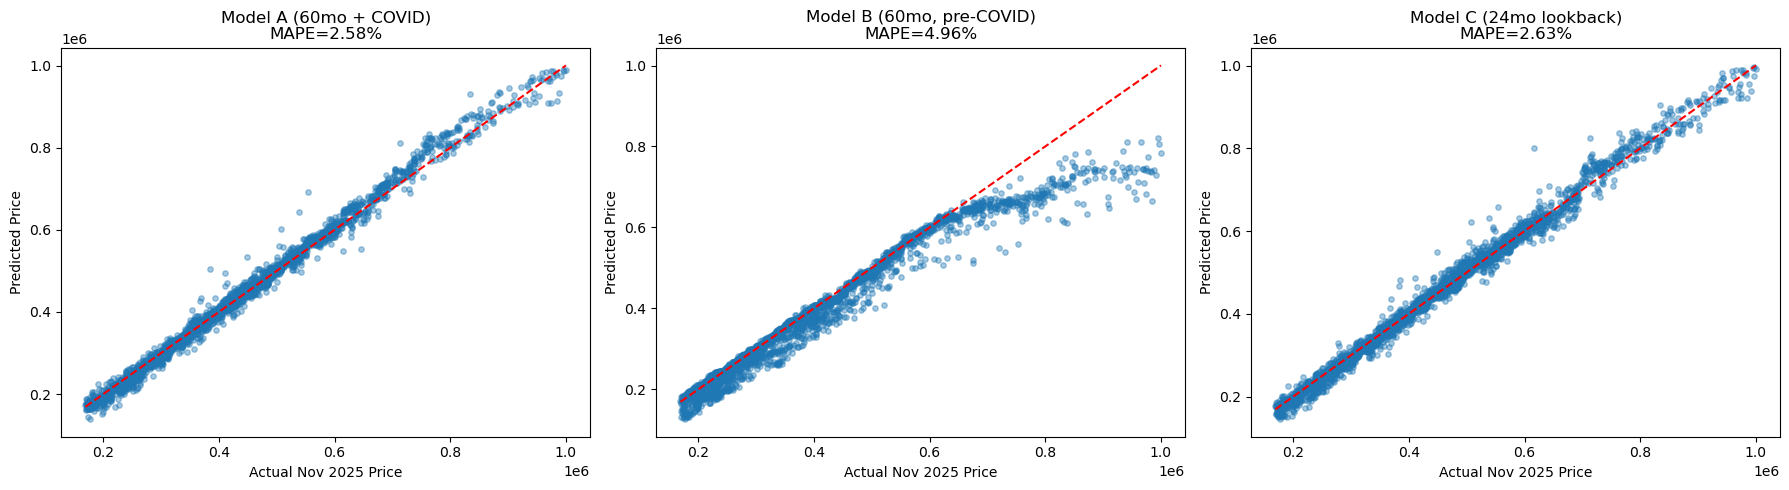

In [30]:
# Visualize all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model A
ax = axes[0]
ax.scatter(y_actual, y_pred_a_fwd, alpha=0.4, s=15)
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
ax.set_xlabel('Actual Nov 2025 Price')
ax.set_ylabel('Predicted Price')
ax.set_title(f'Model A (60mo + COVID)\nMAPE={mape_a_fwd:.2f}%')

# Model B
ax = axes[1]
ax.scatter(y_actual, y_pred_b_fwd, alpha=0.4, s=15)
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
ax.set_xlabel('Actual Nov 2025 Price')
ax.set_ylabel('Predicted Price')
ax.set_title(f'Model B (60mo, pre-COVID)\nMAPE={mape_b_fwd:.2f}%')

# Model C
ax = axes[2]
ax.scatter(y_actual_c, y_pred_c_fwd, alpha=0.4, s=15)
ax.plot([y_actual_c.min(), y_actual_c.max()], [y_actual_c.min(), y_actual_c.max()], 'r--')
ax.set_xlabel('Actual Nov 2025 Price')
ax.set_ylabel('Predicted Price')
ax.set_title(f'Model C (24mo lookback)\nMAPE={mape_c_fwd:.2f}%')

plt.tight_layout()
plt.show()

## Step 8: Key Takeaways

### Model C (24-month lookback) Hypothesis
- **Goal:** Reduce COVID's influence by using a shorter lookback window
- **Changes:** 24-month minimum history, dropped cagr_5yr/cagr_3yr, added cagr_2yr
- **Tradeoff:** More neighborhoods qualify, but less historical context

### Next Steps
Based on results, decide:
1. Which model to deploy to production
2. Whether additional experiments are needed (e.g., weighted training, hybrid approaches)
3. How to handle neighborhoods with different history lengths

## Step 9: Export Model C Predictions for App Integration

Generate 1-year appreciation predictions for all current neighborhoods and save to `appreciation_predictions_current.csv` for the Streamlit app.

In [31]:
# Generate predictions for current neighborhoods using Model C
# Uses October 2025 as "current" and predicts October 2026 prices
#
# IMPORTANT: Only predict for neighborhoods within training population:
# - Price: $170,000 - $1,000,000
# - History: 24+ months
# - Sanity cap: -10% to +15% annual appreciation

print('Generating appreciation predictions for app integration...')
print()

# Price bounds (same as training)
PRICE_MIN = 170000
PRICE_MAX = 1000000

# Sanity bounds for appreciation (prevent unrealistic extrapolation)
APPRECIATION_MIN = -10.0  # -10% floor
APPRECIATION_MAX = 15.0   # +15% ceiling

# Use the full dataset
df_current = df_test_raw.copy()
df_current['training_metro'] = df_current['Metro'].apply(get_training_metro)
df_current['display_metro'] = df_current.apply(get_display_metro, axis=1)

# Apply metro filter
df_current = df_current[df_current['training_metro'].notna()].copy()
print(f'Neighborhoods in target metros: {len(df_current):,}')

# Apply PRICE FILTER (critical - model only trained on this range)
df_current = df_current[
    (df_current[oct_2025_col] >= PRICE_MIN) & 
    (df_current[oct_2025_col] <= PRICE_MAX)
].copy()
print(f'After price filter (${PRICE_MIN/1000:.0f}k - ${PRICE_MAX/1000:.0f}k): {len(df_current):,}')

# Compute metro medians at Oct 2025
metro_medians_current = {}
for metro in df_current['training_metro'].unique():
    metro_prices = df_current[df_current['training_metro'] == metro][oct_2025_col].dropna()
    if len(metro_prices) > 0:
        metro_medians_current[metro] = metro_prices.median()

# Extract features for all neighborhoods (24-month function)
prediction_records = []
skipped_history = 0

for idx, row in df_current.iterrows():
    # Get price history through October 2025
    history = row[date_cols_test[:oct_idx+1]].values.astype(float)
    
    features = extract_features_24m(history, metro_medians_current.get(row['training_metro'], 0))
    
    if features is None:
        skipped_history += 1
        continue  # Skip if insufficient history
    
    current_price = features['prev_price']
    
    # Skip if current price is invalid
    if current_price <= 0 or np.isnan(current_price):
        continue
    
    # Prepare feature vector for prediction
    X_pred = np.array([[features[col] for col in feature_cols_24m]])
    
    # Predict future price
    predicted_price = model_c.predict(X_pred)[0]
    
    # Calculate appreciation rate
    appreciation_rate = ((predicted_price - current_price) / current_price) * 100
    
    # Apply sanity cap (clip to reasonable bounds)
    appreciation_rate_capped = np.clip(appreciation_rate, APPRECIATION_MIN, APPRECIATION_MAX)
    
    prediction_records.append({
        'neighborhood_name': row['RegionName'],
        'metro': row['training_metro'],
        'display_metro': row['display_metro'] if pd.notna(row['display_metro']) else row['training_metro'],
        'city': row['City'],
        'current_price': current_price,
        'predicted_price': predicted_price,
        'predicted_1yr_appreciation': appreciation_rate_capped,
        'raw_appreciation': appreciation_rate  # Keep raw for analysis
    })

df_predictions = pd.DataFrame(prediction_records)
print(f'Skipped (insufficient history): {skipped_history:,}')
print(f'Generated predictions for {len(df_predictions):,} neighborhoods')
print()

# Show how many were capped
capped_low = (df_predictions['raw_appreciation'] < APPRECIATION_MIN).sum()
capped_high = (df_predictions['raw_appreciation'] > APPRECIATION_MAX).sum()
print(f'Sanity caps applied:')
print(f'  Capped to {APPRECIATION_MIN}% floor: {capped_low:,} neighborhoods')
print(f'  Capped to {APPRECIATION_MAX}% ceiling: {capped_high:,} neighborhoods')
print(f'  Within bounds: {len(df_predictions) - capped_low - capped_high:,} neighborhoods')
print()
print('Appreciation rate distribution (after capping):')
print(df_predictions['predicted_1yr_appreciation'].describe().round(2))

Generating appreciation predictions for app integration...

Neighborhoods in target metros: 4,648
After price filter ($170k - $1000k): 4,200
Skipped (insufficient history): 516
Generated predictions for 3,684 neighborhoods

Sanity caps applied:
  Capped to -10.0% floor: 100 neighborhoods
  Capped to 15.0% ceiling: 14 neighborhoods
  Within bounds: 3,570 neighborhoods

Appreciation rate distribution (after capping):
count    3684.00
mean       -0.56
std         3.65
min       -10.00
25%        -2.35
50%        -0.60
75%         1.28
max        15.00
Name: predicted_1yr_appreciation, dtype: float64


In [32]:
# Save predictions to CSV for app integration
# Drop raw_appreciation column (only save the capped values)
output_path = '../data/processed/appreciation_predictions_current.csv'

# Select columns for export (exclude raw_appreciation)
export_cols = ['neighborhood_name', 'metro', 'display_metro', 'city', 
               'current_price', 'predicted_price', 'predicted_1yr_appreciation']
df_export = df_predictions[export_cols].copy()

df_export.to_csv(output_path, index=False)

print(f'Saved {len(df_export):,} predictions to:')
print(f'  {output_path}')
print()
print('Columns:', list(df_export.columns))
print()
print('Sample predictions:')
print(df_export.head(10).to_string(index=False))
print()
print('Appreciation range in export:')
print(f'  Min: {df_export["predicted_1yr_appreciation"].min():.2f}%')
print(f'  Max: {df_export["predicted_1yr_appreciation"].max():.2f}%')

Saved 3,684 predictions to:
  ../data/processed/appreciation_predictions_current.csv

Columns: ['neighborhood_name', 'metro', 'display_metro', 'city', 'current_price', 'predicted_price', 'predicted_1yr_appreciation']

Sample predictions:
   neighborhood_name         metro display_metro      city  current_price  predicted_price  predicted_1yr_appreciation
               Alief       houston       houston   Houston  210612.957438    206494.400026                   -1.955510
           Southeast           dfw    fort_worth Arlington  307937.663708    301235.167434                   -2.176576
                East           dfw    fort_worth Arlington  243387.382122    240373.851561                   -1.238162
             Alafaya       orlando       orlando   Orlando  449660.329950    447933.034531                   -0.384133
                West           dfw    fort_worth Arlington  310689.410875    307804.048781                   -0.928697
             Kendall south_florida         miami

In [33]:
# Save trained Model C for future use
import joblib
from pathlib import Path

# Create artifacts directory
artifacts_dir = Path('../ml/artifacts/model_c')
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save the model
model_path = artifacts_dir / 'price_model.joblib'
joblib.dump(model_c, model_path)

# Save feature columns for reference
feature_info = {
    'feature_cols': feature_cols_24m,
    'min_history_months': 24,
    'model_type': 'RandomForestRegressor',
    'training_years': '2002-2024',
    'forward_validation_mape': mape_c_fwd,
    'forward_validation_r2': r2_c_fwd,
    'n_training_examples': len(df_model_c),
    'n_predictions': len(df_predictions),
    'created': datetime.now().isoformat()
}

import json
with open(artifacts_dir / 'model_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f'Model C saved to: {artifacts_dir}')
print()
print('Artifacts:')
print(f'  - {model_path.name} ({model_path.stat().st_size / 1024 / 1024:.1f} MB)')
print(f'  - model_info.json')
print()
print('Model info:')
for k, v in feature_info.items():
    print(f'  {k}: {v}')

Model C saved to: ../ml/artifacts/model_c

Artifacts:
  - price_model.joblib (87.9 MB)
  - model_info.json

Model info:
  feature_cols: ['prev_price', 'log_prev_price', 'cagr_1yr', 'cagr_2yr', 'cagr_full', 'trend_acceleration', 'momentum_3m', 'volatility', 'downside_volatility', 'max_drawdown', 'distance_from_peak', 'months_since_peak', 'price_to_metro_median', 'data_coverage', 'history_months']
  min_history_months: 24
  model_type: RandomForestRegressor
  training_years: 2002-2024
  forward_validation_mape: 2.626765660144428
  forward_validation_r2: 0.991489817355042
  n_training_examples: 36681
  n_predictions: 3684
  created: 2026-01-01T21:09:17.432304


## Summary

**Model C (24-month lookback) is now integrated:**

- Forward validation: **2.63% MAPE** on November 2025 data
- Coverage: Predictions for all neighborhoods with 24+ months of history
- App integration: `data/processed/appreciation_predictions_current.csv`
- Model artifacts: `ml/artifacts/model_c/`

**To update predictions when new Zillow data arrives:**
1. Download new Zillow ZHVI data
2. Re-run this notebook from the beginning
3. The app will automatically use the updated predictions